In [1]:
pip install tensorflow

In [2]:
!pip install keras

In [3]:
!pip install keras-applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [4]:
pip install opencv-python

In [5]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


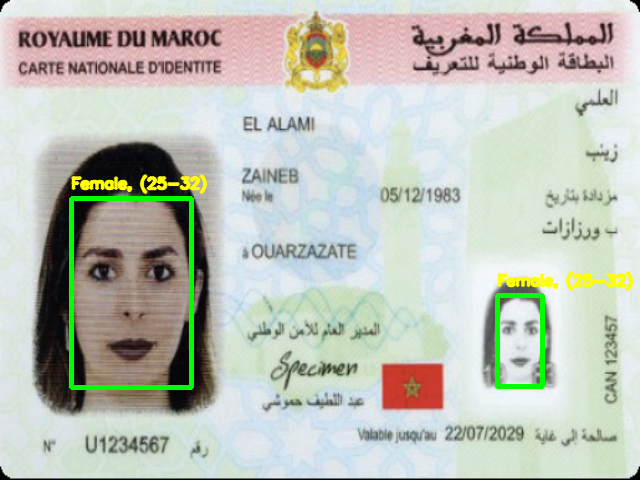

In [7]:
import cv2
from google.colab.patches import cv2_imshow
import argparse

def highlightFace(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    faceBoxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            faceBoxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight / 150)), 8)
    return frameOpencvDnn, faceBoxes


def main(image_path):
    faceProto = "opencv_face_detector.pbtxt"
    faceModel = "opencv_face_detector_uint8.pb"
    ageProto = "age_deploy.prototxt"
    ageModel = "age_net.caffemodel"
    genderProto = "gender_deploy.prototxt"
    genderModel = "gender_net.caffemodel"

    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    genderList = ['Male', 'Female']

    faceNet = cv2.dnn.readNet(faceModel, faceProto)
    ageNet = cv2.dnn.readNet(ageModel, ageProto)
    genderNet = cv2.dnn.readNet(genderModel, genderProto)

    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Impossible de charger l'image à {image_path}")
        return

    # Redimensionner l'image à une taille fixe
    fixed_size = (640, 480)
    frame = cv2.resize(frame, fixed_size)

    resultImg, faceBoxes = highlightFace(faceNet, frame)
    if not faceBoxes:
        print("Aucun visage détecté dans l'image")
        return

    for faceBox in faceBoxes:
        face = frame[max(0, faceBox[1] - 20):min(faceBox[3] + 20, frame.shape[0] - 1),
                     max(0, faceBox[0] - 20):min(faceBox[2] + 20, frame.shape[1] - 1)]

        # Vérifier la taille de la région extraite
        if face.shape[0] == 0 or face.shape[1] == 0:
            print("La région du visage extraite est vide")
            continue

        blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        cv2.putText(resultImg, f'{gender}, {age}', (faceBox[0], faceBox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (0, 255, 255), 2, cv2.LINE_AA)

    cv2_imshow(resultImg)

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--image', required=True)
    args = parser.parse_args(['--image', '/content/okMar.png'])
    main(args.image)